# Preprocessing Ablation Data
---
> Preprocessing amnioserosa ablation movies from Hara et al. 2016

# Hara Ablation Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx, pandas as pd
from simgnn.datautils import simple_moving_average,load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


In [347]:
import glob
from simgnn.hara import get_cell_colormap, read_tiff_stack

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import label_bw_stack, extract_graph

In [463]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [481]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


In [489]:
last_frame_masks = [path.basename(img_name) for img_name in glob.glob(path.join(ablmov_basepath,'frames_masks','*.tif'))]
long_mov_names = recoil_df[recoil_df.AblationFrame>49][['Main folder', 'embryo','Edge ID']]

needs_mask = []
for k in range(len(long_mov_names)):
    mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_mask.tif'
    if mov_name not in last_frame_masks:
        needs_mask.append(k)
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = False
    else:
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = True

long_mov_names.to_csv('/Users/muratshagirov/Desktop/movies_run_avrg/mask_progress.csv')

In [495]:
long_mov_names[(long_mov_names.HasMask)]

,Main folder,embryo,Edge ID,HasMask
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,True
2,140411_Dacat_recoil,sample5,1,True
9,140429_amni_ablation,sample4,1,True
10,140429_amni_ablation,sample4,2,True
11,140429_amni_ablation,sample4,3,True
...,...,...,...,...
162,141212_Dacat_recoil,sample5,1,True
169,141213_Dacat_recoil,sample5,1,True
170,141213_Dacat_recoil,sample6,1,True
172,141213_Dacat_recoil,sample8,1,True


140606_DaCat_recoil_sample3_2.tif
140606_DaCat_recoil_sample3_2_nodes.csv
Image stack shape: (100, 512, 512) -- trim boundaries: False
[171.5, 329.5]


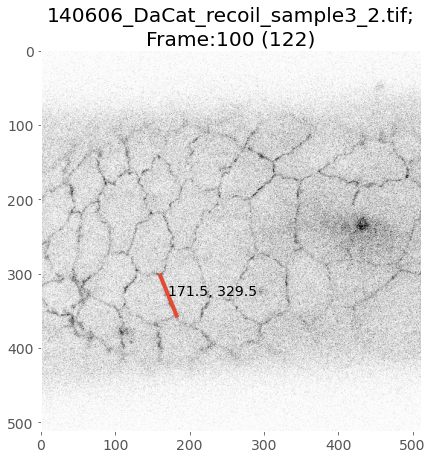

In [497]:
k=needs_mask[0]
mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'.tif'
print(mov_name)
track_csv = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_nodes.csv'
print(track_csv)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',mov_name),trim_bound=False)
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',track_csv))
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print(edge_pos)

plt.imshow(img[-1],cmap='gray_r');plt.grid(False);
plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]], lw=4);
plt.text(edge_pos[0],edge_pos[1],f'{edge_pos[0]:g}, {edge_pos[1]:g}')
plt.title(f'{mov_name};\nFrame:{node_tracking.iloc[-1].frames:n} ({node_tracking.iloc[-1].t:n})');

- Extract Graphs from Amnioserosa Movies

In [29]:
# root_dir = 'simgnn_data/hara_movies/raw/'
# PROCESS_HARA_MOVIE = False # set to true to process Hara AS tissue movies

# if PROCESS_HARA_MOVIE:
#     for bw_img in seg:
#         edges_index, node2cell_index, v_pos = extract_graph(seg[bw_img], label_bw_stack(seg[bw_img])[0])
#         edge_lengths = np.sqrt(((v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:])**2).sum(axis=-1,keepdims=True))

#         dataDir = path.join(root_dir, bw_img)
#         mknewdir(dataDir);

#         write_array(path.join(dataDir, 'edges_index.npy'), edges_index)
#         write_array(path.join(dataDir, 'node2cell_index.npy'), node2cell_index)
#         write_array(path.join(dataDir, 'vtx_pos.npy'), v_pos)
#         write_array(path.join(dataDir, 'edge_Length.npy'), edge_lengths)

# Node Tracking with Napari

**Note** : Restart the jupyter kernel in an env w/ napari !

In [1]:
from skimage import data,io
import napari, numpy as np, glob, pandas as pd
from os import path

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import read_tiff_stack, mask_to_graph, get_cell_colormap

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

In [2]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

---
- **Load Recoil Data**:

In [3]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


---
- **Select sample name**:

In [86]:
Main_folder = '140529_Dacat_recoil' 
embryo = 'sample15'
Edge_ID = '2'

edge_recoil_val = recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID)),'Recoil speed [um/sec]'].values
print(f'Recoil: {edge_recoil_val}')
recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID))]

Recoil: [2.60774]


,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
32,140529_Dacat_recoil,sample15,2,2.60774,0.021227,Rosette,1.02925,1.0-1.1,True,176,5,7,partially occluded 2-neigh-s


---
- **Load Data and Check the Cell Graph**:

Sample:
 | 140529_Dacat_recoil_sample15_2 
Results will be saved in
 | ./simgnn_data/hara_ablation/raw/140529_Dacat_recoil_sample15_2

---
img shape (resampled frames): (10, 512, 512)
Frames:[9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

Node tracks (w/ resampled frames):
     frames    t          x3          y3          x4          y4
9      0.0   85  452.500000  261.166667  409.166667  202.166667
19     1.0   95  452.166667  259.500000  407.833333  202.166667
29     2.0  105  449.500000  260.833333  407.833333  203.166667
39     3.0  115  448.833333  259.833333  406.833333  203.166667
49     4.0  125  448.500000  258.833333  406.166667  201.833333
59     5.0  135  447.833333  258.500000  405.166667  200.833333
69     6.0  145  447.833333  259.166667  405.500000  200.500000
79     7.0  155  448.833333  258.833333  404.833333  199.500000
89     8.0  165  447.833333  258.500000  404.166667  197.833333
99     9.0  175  448.500000  260.833333  404.833333  197.500000

Edge pos (x,y,t=-1):426.7, 

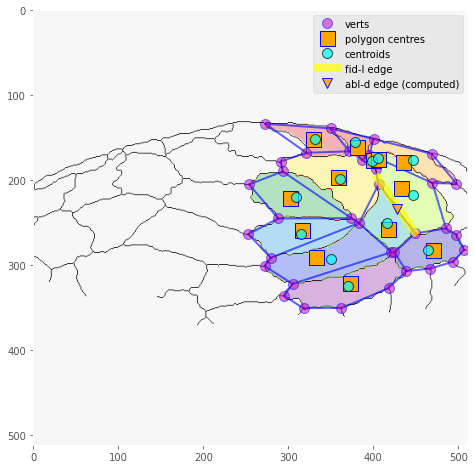

In [87]:
sample_name = '_'.join([Main_folder,embryo,Edge_ID])
save_dir = path.join(data_base_path,'raw',sample_name)
print('Sample:\n |',sample_name,'\nResults will be saved in\n |',save_dir)
mknewdir(save_dir)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',sample_name+'.tif'),trim_bound=False)
last_mask = io.imread(path.join(ablmov_basepath,'frames_masks',sample_name+'_mask.tif'),as_gray=True)

n_frames = img.shape[0]
t = list(reversed(range(n_frames-1,-1,-10)))
img = img[t] # re-sample frames for 10s frame rate
print(f'\n---\nimg shape (resampled frames): {img.shape}\nFrames:{t}')

# Hara et al. ablated edge vertices: fiducials
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',sample_name+'_nodes.csv'))
node_tracking['frames'] = node_tracking['frames']-1 # frames start from 0


# in case if not all frames are tracked
t_frames = [node_tracking[node_tracking['frames']==k].index.values[0]
            for k in reversed(range(n_frames-1,node_tracking['frames'].iloc[0]-1,-10))]
node_tracking = node_tracking.loc[t_frames,:] # re-sample frames for 10s frame rate
node_tracking['frames'] = (node_tracking['frames'] - t[0])/10
print('\nNode tracks (w/ resampled frames):\n',node_tracking)

edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print('\nEdge pos (x,y,t=-1):'+', '.join([f'{vi_x:.1f}' for vi_x in edge_pos]))
# Reshape dimensions for napari
abltd_verts = node_tracking.iloc[:,[0,3,2,0,5,4]].values.reshape(-1,2,3)
# order of the variables for napari : node_tracking.iloc[:,[0,3,2,0,5,4]]

print('---\nExtracting graph:')
# Approximate edge length scaling for ROI size
s=70/np.sqrt(((node_tracking.iloc[-1,[2,3]].values- node_tracking.iloc[-1,[4,5]].values)**2).sum())
print(f'Edge scale (s):{s}')

v0_pos,edges_index,node2cell_index,(Ls_new, Cpos_new) = mask_to_graph(last_mask,
                                                             node_tracking.iloc[-1,[2,3]].values, node_tracking.iloc[-1,[4,5]].values,
                                                                     s=s)
# edge closest to the fiducials
abltd_edge_id = np.argmin(np.sum((0.5*(v0_pos[edges_index[0]]+v0_pos[edges_index[1]]) - np.array(edge_pos))**2,axis=1))
abltd_edge_pos = v0_pos[edges_index[:,abltd_edge_id]].mean(axis=0)
# edge_recoils array for saving
edge_recoils=np.empty((edges_index.shape[1],))
edge_recoils.fill(np.nan)
edge_recoils[abltd_edge_id] = edge_recoil_val
print(f'Recoils: {edge_recoils}')

cell_ids = [ci for ci in np.unique(Ls_new) if ci>0]
print(f' | #verts:{v0_pos.shape[0]}; #edges:{edges_index.shape[1]}; #cells:{len(cell_ids)} ({cell_ids})')

plt.figure(figsize=[8,8])
cmap, norm = get_cell_colormap(Ls_new.max()+3, cmap_0=(0.8, 0.8, 0.8, 0.5))

plt.imshow(last_mask,cmap='gray_r')
plt.imshow(Ls_new, cmap=cmap,norm=norm, alpha=.3)

for e in edges_index.T:
    plt.plot(v0_pos[e,0],v0_pos[e,1],'b-',lw=2,alpha=.6)
plt.plot(v0_pos[:,0],v0_pos[:,1],'mo',mec='b',ms=10,alpha=.5, label='verts')

cell_polygon_pos = np.array([v0_pos[node2cell_index[0,node2cell_index[1]==ci],:].mean(axis=0)
                             for ci in np.unique(node2cell_index[1])])
plt.plot(cell_polygon_pos[:,0],cell_polygon_pos[:,1],'s',c='orange',ms=15,mec='b',label='polygon centres')
plt.plot(Cpos_new[:,0],Cpos_new[:,1],'o',c='cyan',mec='k',ms=10,alpha=.7,label='centroids')

plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]],'-',c='yellow',lw=8,alpha=.7,label='fid-l edge')
plt.plot(abltd_edge_pos[0], abltd_edge_pos[1],'v',c='orange',ms=10,mec='b',alpha=.9,label='abl-d edge (computed)')

plt.legend();plt.grid(False);plt.show()

In [6]:
# node2cell_index[1,node2cell_index[0]==35]

In [7]:
# node2cell_index[:,node2cell_index[1]==13]

In [93]:
e_indx = 25
edges_index[:,np.logical_or(edges_index[0]==e_indx,edges_index[1]==e_indx)]

array([[19, 25, 25],
       [25, 26, 32]])

---
- **Manually Track Vertices w/ napari**:

In [88]:
viewer = napari.view_image(img,name='movie',colormap='inferno')
# mask_layer = viewer.add_image(last_mask,name='mask',colormap='green',blending='additive',opacity=.5)
abltd_v_layer = viewer.add_shapes(abltd_verts,name='abltn',shape_type='line', edge_width=5,edge_color='red',blending='additive',opacity=.5)

# add vertices as point layers for tracking
colors= plt.cm.nipy_spectral(np.linspace(0,1,v0_pos.shape[0]))[np.random.permutation(v0_pos.shape[0])]
verts_layers = {}

verts_pos0 = np.concatenate([(img.shape[0]-1)*np.ones((v0_pos.shape[0],1)), v0_pos[:,[1]], v0_pos[:,[0]]],axis=1)
for k in range(v0_pos.shape[0]):
    verts_layers[k] = viewer.add_points([verts_pos0[k]],ndim=3,name=f'v{k}',size=3,
                                        face_color=colors[k],edge_color=colors[k],
                                        properties={'label':[k]},
                                        text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})

In [52]:
# v0_pos = np.concatenate([v0_pos,np.array([[26,296],[172,372],[97,373],[69,349]])],axis=0)

In [64]:
# edges_index=np.concatenate([edges_index, np.array([[16,8],[13,19],[19,18],[18,17],[17,15]],dtype=edges_index.dtype).T],axis=1)

In [75]:
# node2cell_index=np.concatenate([node2cell_index,np.array([[k,5] for k in [12,13,19,18,17,15] ],dtype=node2cell_index.dtype).T],axis=1)

In [75]:
# new_k =22
# verts_layers[new_k] = viewer.add_points(ndim=3,name=f'v{new_k}',size=3,
#                                     face_color=colors[0],edge_color=colors[0],
#                                     properties={'label':[new_k]},
#                                     text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})
# node2cell_index = np.concatenate([node2cell_index, np.array([[22],[7]])],axis=1)
# edges_index[:,-1] = np.array([18,22])
# edges_index = np.concatenate([edges_index, np.array([[22],[21]])],axis=1)
# edge_recoils=np.concatenate([edge_recoils, np.array([np.nan])])

---
- **Copy tracked vertex positions to a new array for saving**

In [97]:
[(k,l) for k,l in enumerate(map(len,verts_pos)) if l!=10]

[]

In [96]:
verts_pos = [ verts_layers[k].data[np.argsort(verts_layers[k].data[:,0])].copy() for k in verts_layers]

# reshape to make it compatible w/ VertexDynamics dataset class
vtx_pos = np.transpose(np.stack([v_t[:,[2,1]] for v_t in verts_pos],axis=0), (1,0,2))
print(f'vtx_pos :{vtx_pos.shape}')
# print (just in case napari crashes)
verts_pos

vtx_pos :(10, 37, 2)


[array([[  0.        , 131.89692494, 274.17489327],
        [  1.        , 132.60504665, 275.59113668],
        [  2.        , 133.07712778, 271.10636588],
        [  3.        , 132.36900608, 271.57844702],
        [  4.        , 131.89692494, 270.87032531],
        [  5.        , 131.89692494, 270.39824417],
        [  6.        , 134.02129006, 271.57844702],
        [  7.        , 134.02129006, 274.88301498],
        [  8.        , 132.84108722, 273.46677157],
        [  9.        , 133.5       , 273.        ]]),
 array([[  0.        , 133.31316745, 355.84493   ],
        [  1.        , 134.72941086, 353.95660545],
        [  2.        , 137.56189769, 356.31701113],
        [  3.        , 139.45022224, 357.73325455],
        [  4.        , 139.6862628 , 353.24848374],
        [  5.        , 138.50605996, 349.94391578],
        [  6.        , 138.74210053, 347.11142896],
        [  7.        , 137.79793826, 345.22310441],
        [  8.        , 136.85377598, 349.47183465],
        [ 

In [63]:
# colors= plt.cm.RdYlGn(np.linspace(0,1,len(verts_pos)))
# verts_layers = {}
# for k in range(len(verts_pos)):
#     verts_layers[k] = viewer.add_points(verts_pos[k],ndim=3,name=f'v{k}',properties={'label':k*np.ones((6,),dtype=np.int_)},
#                                         text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'},
#                                         size=3,face_color=colors[k],edge_color=colors[k])

In [98]:
# Save frames
write_array(path.join(save_dir,'frames.npy'), np.array(t) )

#vert positions array: #frames, #verts, #dims(==2)
write_array(path.join(save_dir,'vtx_pos.npy'), vtx_pos )

# edges index 2xN_edges
write_array(path.join(save_dir,'edges_index.npy'), edges_index )
# edge recoil, recoil value at ablated edge and np.nan otherwise
write_array(path.join(save_dir,'edge_recoils.npy'), edge_recoils )

# nodes to cells edges
write_array(path.join(save_dir,'node2cell_index.npy'), node2cell_index )

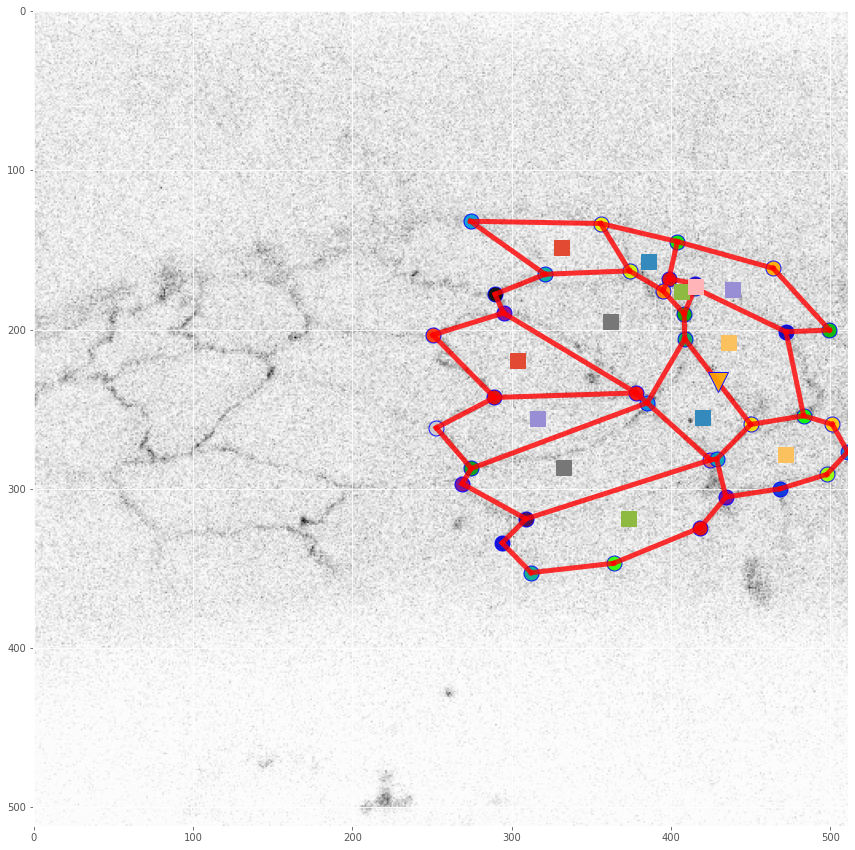

In [99]:
plt.figure(figsize=[15,15])
t_plt = 0
plt.imshow(img[t_plt],cmap='gray_r')

# colors= plt.cm.nipy_spectral(np.linspace(0,1,vtx_pos.shape[1]))[np.random.permutation(vtx_pos.shape[1])]
for k,vk in enumerate( vtx_pos[t_plt]):
    plt.plot(vk[0],vk[1],'o',c=colors[k],mec='b',ms=15,alpha=.9)
for e in edges_index.T:
    plt.plot(vtx_pos[t_plt][e,0],vtx_pos[t_plt][e,1],'r',lw=5,alpha=.8)
    
for ci in np.unique(node2cell_index[1]):
    ci_vk = node2cell_index[0,node2cell_index[1]==ci]
    ci_pos = vtx_pos[t_plt][ci_vk,:].mean(axis=0)
    plt.plot(ci_pos[0],ci_pos[1],'s',ms=15)

# edge closest to the fiducials
abltd_edge_id = np.argmin(np.sum((0.5*(vtx_pos[t_plt][edges_index[0]]+vtx_pos[t_plt][edges_index[1]]) - np.array(edge_pos))**2,axis=1))
abltd_edge_pos = vtx_pos[t_plt][edges_index[:,abltd_edge_id]].mean(axis=0)
plt.plot(abltd_edge_pos[0], abltd_edge_pos[1],'v',c='orange',ms=20,mec='b',alpha=.9,label='abl-d edge (computed)');